In [1]:
import sys
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from IPython.display import Image
import time
#%matplotlib inline

# Example nanoparticle analysis
Applying the functions in `AnalysisTools.py` to characterise nanoparticles in implicit solvent. This is serve as an example when applying the tools to larger data sets and simulations in implicit solvent.

In [3]:
sys.path.append("../Analysis")
from AnalysisTools import * 

## Ligand 2M

Loading the trajectory into MD traj:

In [3]:
traj = md.load('2m/trajectory.dcd',top="2m/snapshots.pdb")

**TIMING FUNCTION**

Seeing how long it takes to compute the solvent accessible volume over the trajectory...

In [4]:
t = time.time()
c, av_vol,vol = compressibilty(traj,('LIG','DYE'),skip=0)
print 'Finished in {0} seconds'.format(time.time() - t )

Finished in 916.829304934 seconds


It takes 917 seconds = 15.3 minutes!

**TIME SERIES ANALYSIS**

Calculating the equilibration time, the statisitical ineffeciency, and number of uncorrelated samples.

In [5]:
from pymbar import timeseries as ts

(t,g,n) = ts.detectEquilibration(vol)  
# Start of equil time, stat inefficiency, num uncorrelated sample
print 'Start of equilibrium = {0}, stat. inefficiency = {1} number uncorrelated samples = {2}'.format(t,g,n)

Start of equilibrium = 0, stat. inefficiency = 1.0 number uncorrelated samples = 201.0


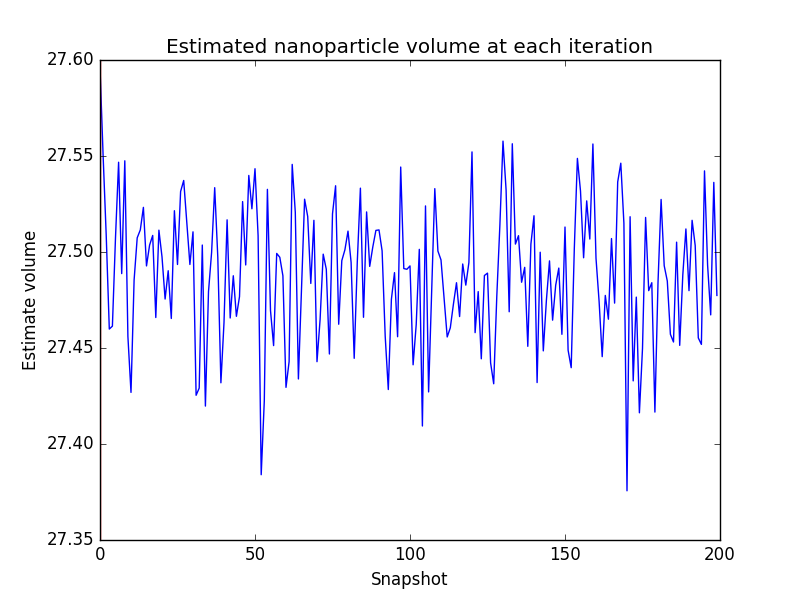

In [6]:
plt.plot(vol)
plt.axvline(x=t, ymin=0, ymax = 100,color="red")
plt.xlabel('Snapshot')
plt.ylabel('Estimate volume')
plt.title('Estimated nanoparticle volume at each iteration')
plt.savefig('Volume_2m.png',format='png')
Image('Volume_2m.png')

The red line shows the start of the equilibration time.

## All ligands

Applying each descriptor to the nanoparticles formed by each compound. Standardising them, and seeing if it's possible to descriminate those that actually form nanoparticles from those that don't.

In [5]:
ligs = ['1e','2m','3t','4r','5s','6s','7t','8t','9t','10v']

descriptors = []
t = time.time()
for l in ligs:
    traj = md.load(l+'/trajectory.dcd',top=l+"/snapshots.pdb")
    c, av_vol,vol = compressibilty(traj,('LIG','DYE'),skip=600)
    m, av_sasa = morphability(traj,('LIG','DYE'),skip=600)
    phi = sphericity(av_vol,av_sasa)
    trash, vol_dye = ResidueVolume(traj,'DYE')
    trash, vol_mol = ResidueVolume(traj,'LIG')
    pe = (vol_mol+vol_dye)/av_vol    # Packing efficiency
    descriptors.append([c,m,phi,pe])
t = time.time() - t
print "It look {0} seconds to process {1} simulations".format(t,len(ligs))

It look 8895.28437901 seconds to process 10 simulations


In [6]:
def standardise(A):
    return(A - np.mean(A, axis=0)) / np.std(A, axis=0)

des = np.array(descriptors)
des = standardise(descriptors)

In [9]:
des

array([[ 0.18263378, -0.33637152,  0.04829871, -0.40323382],
       [-0.92273344, -1.2758494 ,  1.27691654, -0.20621727],
       [ 0.33496161,  1.01195691,  0.77665493,  0.62534314],
       [ 1.221911  ,  0.98075983, -1.59226289, -2.56355541],
       [-1.63870599, -1.28957176, -0.10826687,  0.20862868],
       [-0.93046896, -0.41861486,  1.87472984,  0.85278088],
       [-0.38798065,  1.60757083, -0.31622351,  1.28498054],
       [ 1.46922317,  0.53137365, -0.20739172, -0.09577617],
       [-0.50835127,  0.38151164, -0.98523618,  0.57088601],
       [ 1.17951074, -1.19276532, -0.76721885, -0.27383658]])

## Hierachical clustering
Selecting 2 groups based entirely on similarity. Can I distinguish between drugs that form nanoparticles from those that don't in an unsupervised way?

In [28]:
from scipy.cluster import hierarchy
from scipy.spatial import distance
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline 

In [25]:
# Root mean-squared distance 
RMSDs = np.zeros((des.shape[0], des.shape[0]))
for i in range(des.shape[0]):
    x=des-des[i]
    y=np.sum(x**2,axis=1)
    RMSDs[i,:] = np.mean(y)**(1./2)
#RMSDs = distance.squareform(RMSDs) # Correcting the formating for clustering.

  # The clustering bit.
z = hierarchy.linkage(RMSDs,method='average',metric='euclidean')
#Clusts = hierarchy.fcluster(z,t=2,criterion='criterion')


AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

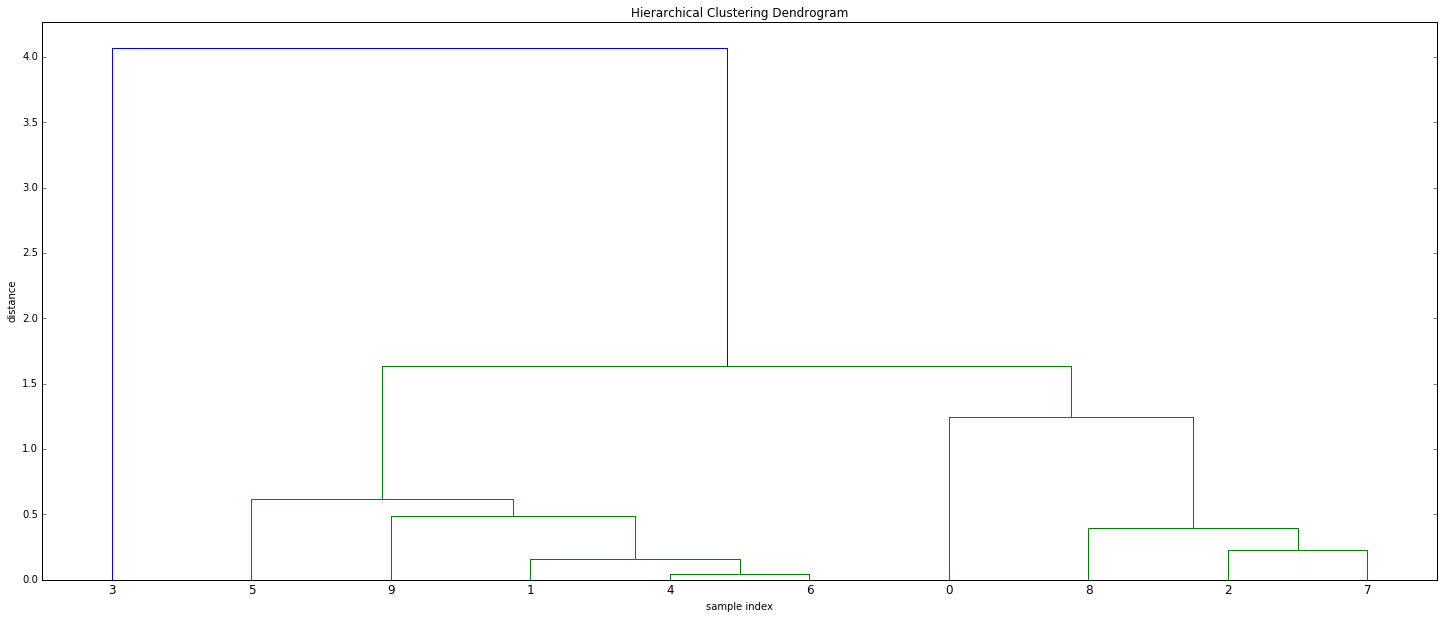

In [29]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(z)
plt.show()